In [1]:
import numpy as np
from sklearn import preprocessing
import heapq
import operator
from collections import defaultdict
import time

In [45]:
m = 2**10
r = 0.4
k = 20
d = 32
RANDOM_SEED = 42
SAMPLE_NUMBER = 10**2
QUERY_NUMBER = 100
mu, sigma = 0, 1 # mean and standard deviation

%run Dsearch.ipynb

In [46]:
#generate 'SAMPLE_NUMBER' of random normalized vectors with length'd'
def sample():
    vectors = np.random.normal(mu, sigma, [SAMPLE_NUMBER, 32])
    vectors = preprocessing.normalize(vectors, norm='l2')
    
    return vectors

In [54]:
#generate hash for all vectors
def hasher(vectors, m, r, hash_func, d = 32):
    if(hash_func == GaussianHasher):
        hash_func = GaussianHasher(d,m,r)
    else:
        hash_func = FourierHasher(d,m,r)
        
    hash_list = []
    for vec in vectors:
        hash_list.append(hash_func.encode(vec))
        
    return hash_list

In [55]:
#pick a randrom vector as the query vector
def randomize(random_state):
    index = random_state.random_integers(low = 0, high = SAMPLE_NUMBER)
    return index

In [56]:
def intersection(lst1, lst2):
    return set(lst1).intersection(lst2)

#calculate number of hash collisions
def hashSimilarity(lst1, lst2):
    return len(intersection(lst1,lst2))

#calculate the dot similarity 
def dotSimilarity(lst1, lst2):
    return np.dot(lst1,lst2)

In [57]:
def build_similarities(query_id, vectors):
    ''' suppose vectors[i, :] is a single vector in your set;
        that is, vectors is a numpy array, where each row is normalized
        to l2-norm=1
        
        returns a numpy vector of similarities: the i'th entry is the similarity
        between the i'the vector and the query_id vector
    '''
    return vectors.dot(vectors[query_id])

In [58]:
def build_index(hash_list):
    ''' returns a dictionary of lists, where the keys are
        hash tokens, and the values of the lists are document ids
    '''
    index = defaultdict(list)
    for k, hash_itemlist in enumerate(hash_list):
        for h in hash_itemlist:
            
            index[h].append(k)
            
    return index

In [59]:
def score_by_hash_collision(query_id, index, hash_list):
    ''' return a dictionary:  keys are document id's, and
        values are scores
    '''
    scores = defaultdict(int)
    for h in hash_list[query_id]:
        for doc_id in index[h]:
            scores[doc_id] += 1
    return scores

In [13]:
'''calculate mean and median for a given hash function, m, and r. We compare the number of similar results 
from the hash and our ground truth(dot_similarity) for each of the QUERY_NUMBER queries. '''
def calculate(m, r, hash_func):
    
    vectors = sample()
    random_state = np.random.RandomState(RANDOM_SEED)   
    duplicate_list = []
    hash_list = hasher(vectors, m, r, hash_func)
    index = build_index(hash_list)
    
    for i in range (QUERY_NUMBER):
        random_query_id = randomize(random_state)
        scores_truth = build_similarities(random_query_id, vectors)
        topk_truth = heapq.nlargest(k, list(enumerate(scores_truth)), key = operator.itemgetter(1))
        
        scores_hash = score_by_hash_collision(random_query_id, index, hash_list)
        topk_hash = heapq.nlargest(k, list(scores_hash.items()), key = operator.itemgetter(1))
   
        duplicate = len(intersection(topk_truth,topk_hash))
        duplicate_list.append(duplicate)
       
    print("m:{} r:{}, hashFunc:{}".format(m, r, hash_func))
    mean = np.mean(duplicate_list)
    median = np.median(duplicate_list)
    
    return mean, median
        
        

In [ ]:
import time

m = [2**13, 2**17, 2**20, 2**23]
r = [0.2, 0.4, 0.6]
hash_func = [GaussianHasher, FourierHasher]

mean = np.zeros((len(m), len(r),len(hash_func)))
median = np.zeros((len(m), len(r),len(hash_func)))
time_list = np.zeros((len(m), len(r),len(hash_func)))


for i,m_value in enumerate(m):
    for j,r_value in enumerate(r): 
        for k,func in enumerate(hash_func):
            start_time = time.time()
            mean[i,j,k], median[i,j,k] = calculate(m_value, r_value, func)
            time_list[i,j,k] = time.time() - start_time
            print("mean:{}, median:{}, time:{}\n".format(mean[i,j,k], median[i,j,k], time_list[i,j,k]))


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 1000000 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


m:8192 r:0.2, hashFunc:<class '__main__.GaussianHasher'>
mean:0.0, median:0.0, time:779.9910469055176

m:8192 r:0.2, hashFunc:<class '__main__.FourierHasher'>
mean:0.0, median:0.0, time:505.8917622566223

m:8192 r:0.4, hashFunc:<class '__main__.GaussianHasher'>
mean:0.0, median:0.0, time:400.48907589912415

m:8192 r:0.4, hashFunc:<class '__main__.FourierHasher'>
mean:0.0, median:0.0, time:211.09454464912415

m:8192 r:0.6, hashFunc:<class '__main__.GaussianHasher'>
mean:0.0, median:0.0, time:367.18861198425293

m:8192 r:0.6, hashFunc:<class '__main__.FourierHasher'>
mean:0.0, median:0.0, time:205.24553513526917



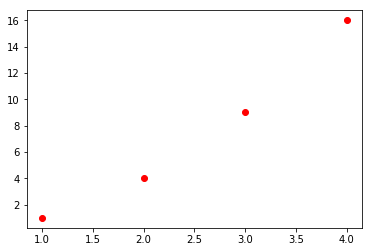

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
plt.plot([1,2,3,4], [1,4,9,16], 'ro')



In [137]:
print(mean)
print(median)

[[ 0.55  0.02  0.02]
 [ 4.83  0.08  0.  ]
 [11.74  0.36  0.04]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]
[[ 0.  0.  0.]
 [ 5.  0.  0.]
 [12.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
